In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import tensorflow as tf

In [16]:
# 0. 데이터 분포 확인
boston = load_boston()
boston_df = pd.DataFrame(boston['data'],
                         columns=boston['feature_names'])
boston_df['house_price'] = boston['target']
boston_df.head(10)
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,house_price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [17]:
# 1. dataset nomalize수행 + standardization
xs_norma = (boston_df.iloc[:,:-1] - boston_df.iloc[:,:-1].min(axis=0)) / (boston_df.iloc[:,:-1].max(axis=0) - boston_df.iloc[:,:-1].min(axis=0))
label = np.reshape(np.array(boston_df.iloc[:,-1]),[-1,1])
print(xs_norma.describe())
xs = xs_norma.values.copy()
print(label.shape)
print(xs.shape)


             CRIM          ZN       INDUS  ...     PTRATIO           B       LSTAT
count  506.000000  506.000000  506.000000  ...  506.000000  506.000000  506.000000
mean     0.040544    0.113636    0.391378  ...    0.622929    0.898568    0.301409
std      0.096679    0.233225    0.251479  ...    0.230313    0.230205    0.197049
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      0.000851    0.000000    0.173387  ...    0.510638    0.945730    0.144040
50%      0.002812    0.000000    0.338343  ...    0.686170    0.986232    0.265728
75%      0.041258    0.125000    0.646628  ...    0.808511    0.998298    0.420116
max      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000

[8 rows x 13 columns]
(506, 1)
(506, 13)


In [0]:
class Layer:
    def forward(self, x):
        """
        해당 Operation의 순전파를 계산
        """
        raise NotImplementedError
        
    def backward(self, grad):
        """
        해당 Operation의 역전파를 계산
        """
        raise NotImplementedError
        
    def update(self, learning_rate):
        """
        [optional]
        해당 Layer에 Weight가 있다면,
        w_old = w_new - learning_rate * dw
        """
        pass

class logit_layer(Layer) :
    def __init__(self, w_size, b_size):
        self.w = np.random.normal(loc= 0.0, scale=2/w_size[1], size = w_size)
        self.b = np.zeros(shape = b_size)
        self.b = np.reshape(self.b, (1,-1))
        #print("w_shape : ", self.w.shape)
         
    def forward(self, x) :
        self.x = x
        #print(self.b.shape)
        z = np.matmul(self.x, self.w) 
        z = z + self.b #dataframe에서 matmul axis issue, np.dot은 없음
        return z
    
    def backward(self, grad) :
        # dz/dw **
        self.del_w = np.matmul(grad.T, self.x) #미리 식 세워놓음(=? Dynamic programing )    
        # (2, d)*(d, 3)
        self.del_b = np.mean(grad, axis =0)   #**  
        
        # dz/dx **
        self.del_a = np.matmul(grad, self.w.T)
        return self.del_a
        
    def update(self, learning_rate) :
        #print("w.shape : {}, del_w.shape : {}".format(self.w.shape, self.del_w.shape))
        self.w = self.w - (learning_rate * self.del_w.T)
        self.b = self.b - (learning_rate * self.del_b)
        pass
        
class relu_layer(Layer) :     
    def forward(self, z) :
        self.z = z
        return np.maximum(self.z, 0)
    
    def backward(self,grad) :
        return grad * np.where(self.z > 0  , 1, 0)
    
class sigmoid_with_loss(Layer) :
    def __init__(self, p) : 
        self.p = np.reshape(np.array(p), (-1,1)) #label

    def forward(self, z): #z는 계산된값
        self.z = z
        #sig
        #self.q = 1/(1 + np.exp(-self.z))
        #print(self.q.shape, "label:", self.p.shape)
        #cee 계산
        #print("q : {}".format(self.q))
        #self.loss = -np.mean((self.p * np.log(self.q))+((1-self.p) * np.log(1-self.q)), axis = 0)
        self.loss = np.mean((self.z - self.p)**2, axis =0)
        #self.acc = np.mean(np.equal(np.where(self.q > 0.5, 1., 0.), p) ,axis =0)
        return self.loss

    def backward(self, grad) : #dL/dz = (y_h - y)
        #sig with CEE의 loss 계산 == MSE loss **
        self.del_loss = (self.z - self.p)
        self.del_loss = self.del_loss #**
        return self.del_loss

    
    

In [50]:
#print(label.shape)
#(506, 1)
#print(xs.shape)
#(506, 13)

logit1 = logit_layer([13,100], 100)
relu1 = relu_layer()
logit2 = logit_layer([100,1],1)
sig_with_loss = sigmoid_with_loss(label)


for epoch in range(30000) :
    z1 = logit1.forward(xs)
    acti1 = relu1.forward(z1)
    pred = logit2.forward(acti1)

    loss_ = sig_with_loss.forward(pred)
    
    if epoch % 500 == 0 :
        #print(pred)
        print("epoch : {}".format(epoch))
        print("loss : {}".format(loss_))
        rmse = np.sqrt(np.mean((pred - label)**2, axis = 0))
        print("rmse : {}".format(rmse))
        print("========================")
    
    del_loss = sig_with_loss.backward(1)
    del_logit2 = logit2.backward(del_loss)
    del_acti1 = relu1.backward(del_logit2)
    del_logit1 = logit1.backward(del_acti1)
    
    logit1.update(0.001)
    logit2.update(0.001)
    

plt.plot(pred, label)




epoch : 0
loss : [587.35942066]
rmse : [24.23549918]


ValueError: ignored

[[22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280632]
 [22.53280

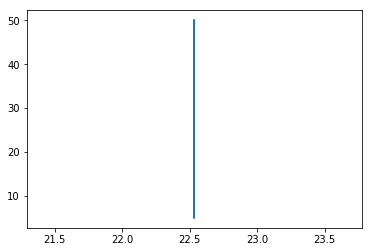

In [44]:
pred_ = np.reshape(pred, (-1,))
label_ = np.reshape(label, (-1))
print(pred)
plt.plot(pred_, label_)
